In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
!nvidia-smi

Sat Sep 25 04:36:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     / 10.4 MB 849 kB/s
     |████████████████████████████████| 180 kB 5.5 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 139 kB 40.0 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 70 kB 7.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=f1a5d4d961c6b655b150ba40b52f7f33acaaec0b755087e0668ed895c359c9b4
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=e40e3006ba51b7f613a863074c2280a2d75a1400b0474abe323aa3a3d2a6d709
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=05f1d9ed5bcca06cfacdef0956fcf

In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
simclr_weights = wandb.restore("20200509-042927resnet_simclr.h5", run_path="sayakpaul/simclr/simclr-learning")

In [6]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [7]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 35.72 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [8]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [9]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [10]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [11]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 125/125 [00:00<00:00, 156.37it/s]


(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 172.42it/s]


(250, 224, 224, 3) (250,)


In [12]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [13]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [14]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [15]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [16]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [17]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [18]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [19]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 1s 245ms/step - loss: 3.2921 - accuracy: 0.1520 - val_loss: 3.1284 - val_accuracy: 0.1720
Epoch 2/35
2/2 [==============================] - 0s 41ms/step - loss: 3.0968 - accuracy: 0.1840 - val_loss: 2.9670 - val_accuracy: 0.1960
Epoch 3/35
2/2 [==============================] - 0s 30ms/step - loss: 2.9171 - accuracy: 0.1840 - val_loss: 2.8208 - val_accuracy: 0.2120
Epoch 4/35
2/2 [==============================] - 0s 31ms/step - loss: 2.7602 - accuracy: 0.2080 - val_loss: 2.6891 - val_accuracy: 0.2200
Epoch 5/35
2/2 [==============================] - 0s 38ms/step - loss: 2.6197 - accuracy: 0.2240 - val_loss: 2.5698 - val_accuracy: 0.2240
Epoch 6/35
2/2 [==============================] - 0s 31ms/step - loss: 2.4881 - accuracy: 0.2160 - val_loss: 2.4662 - val_accuracy: 0.2240
Epoch 7/35
2/2 [==============================] - 0s 37ms/step - loss: 2.3851 - accuracy: 0.2240 - val_loss: 2.3732 - val_accuracy: 0.2520
Epoch 8/35
2/2 [==========

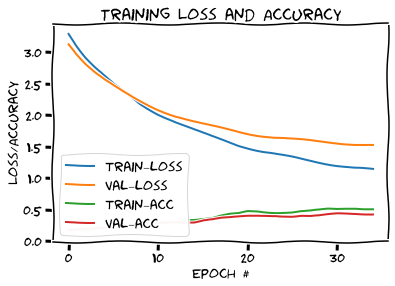

In [20]:
# Linear model
wandb.init(project='simclr_tf', entity='raghavaurs', id="linear-eval-relu-last")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [21]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 1s 176ms/step - loss: 4.2579 - accuracy: 0.2080 - val_loss: 3.3758 - val_accuracy: 0.2880
Epoch 2/35
2/2 [==============================] - 0s 49ms/step - loss: 3.6774 - accuracy: 0.2320 - val_loss: 2.9739 - val_accuracy: 0.3200
Epoch 3/35
2/2 [==============================] - 0s 35ms/step - loss: 3.2152 - accuracy: 0.2640 - val_loss: 2.6924 - val_accuracy: 0.3120
Epoch 4/35
2/2 [==============================] - 0s 46ms/step - loss: 2.8918 - accuracy: 0.3440 - val_loss: 2.4917 - val_accuracy: 0.3480
Epoch 5/35
2/2 [==============================] - 0s 51ms/step - loss: 2.6272 - accuracy: 0.3600 - val_loss: 2.3367 - val_accuracy: 0.3280
Epoch 6/35
2/2 [==============================] - 0s 50ms/step - loss: 2.4562 - accuracy: 0.3680 - val_loss: 2.2121 - val_accuracy: 0.3280
Epoch 7/35
2/2 [==============================] - 0s 44ms/step - loss: 2.3009 - accuracy: 0.3680 - val_loss: 2.0939 - val_accuracy: 0.3400
Epoch 8/35
2/2 [==========

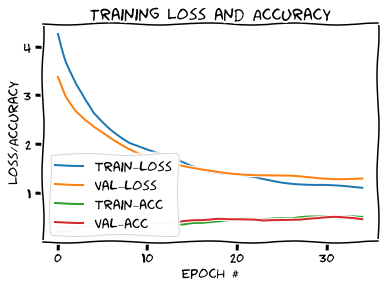

In [22]:
wandb.init(project='simclr_tf', entity='raghavaurs', id="linear-eval-relu-second-last")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [23]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 1s 190ms/step - loss: 2.7828 - accuracy: 0.1600 - val_loss: 2.4757 - val_accuracy: 0.0800
Epoch 2/35
2/2 [==============================] - 0s 49ms/step - loss: 2.3337 - accuracy: 0.1040 - val_loss: 1.8767 - val_accuracy: 0.2760
Epoch 3/35
2/2 [==============================] - 0s 46ms/step - loss: 1.6491 - accuracy: 0.3280 - val_loss: 1.6210 - val_accuracy: 0.2840
Epoch 4/35
2/2 [==============================] - 0s 36ms/step - loss: 1.4216 - accuracy: 0.3600 - val_loss: 1.3160 - val_accuracy: 0.5040
Epoch 5/35
2/2 [==============================] - 0s 40ms/step - loss: 1.2214 - accuracy: 0.5120 - val_loss: 1.2984 - val_accuracy: 0.4840
Epoch 6/35
2/2 [==============================] - 0s 34ms/step - loss: 1.1923 - accuracy: 0.4320 - val_loss: 1.2888 - val_accuracy: 0.4800
Epoch 7/35
2/2 [==============================] - 0s 34ms/step - loss: 1.1077 - accuracy: 0.5360 - val_loss: 1.2982 - val_accuracy: 0.4600
Epoch 8/35
2/2 [==========

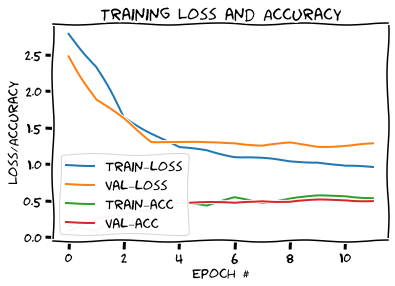

In [24]:
wandb.init(project='simclr_tf', entity='raghavaurs', id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

**Visualization of the representations**

In [25]:
wandb.init(project="simclr_tf", entity="raghavaurs", id="visualization")

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/raghavaurs/simclr_tf/runs/visualization

In [26]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


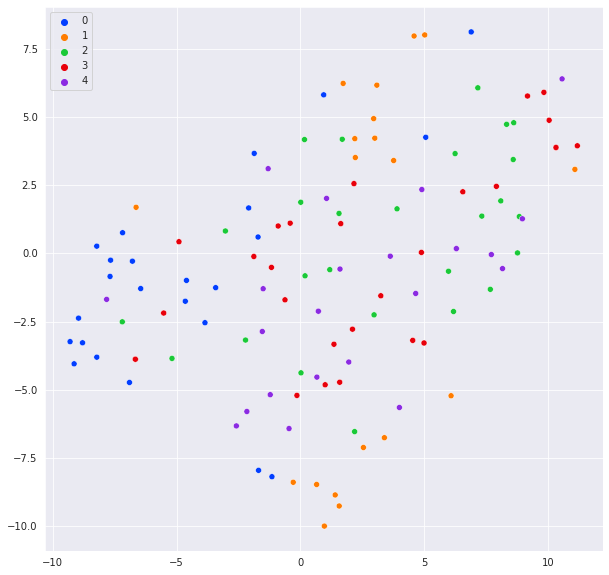

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [27]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



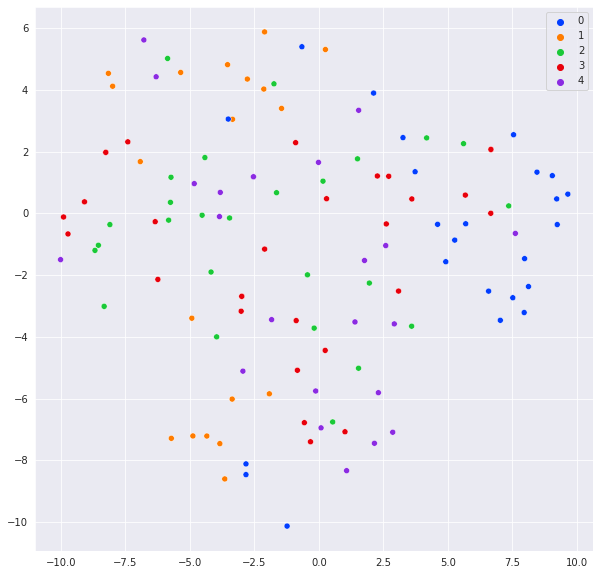

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [28]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"second_last_relu": fig})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



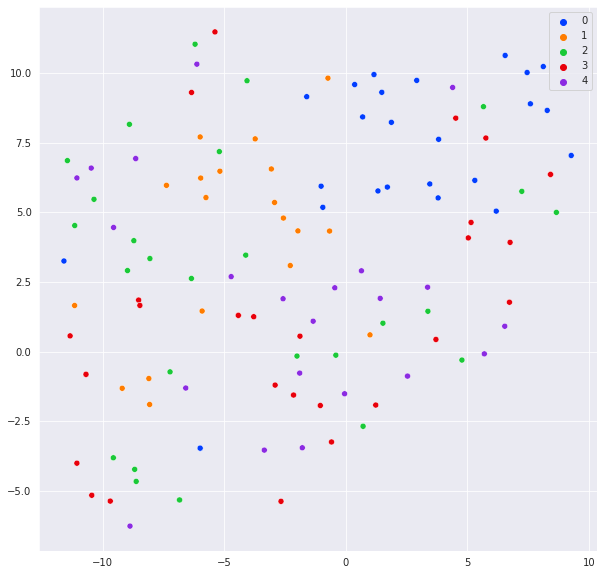

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [29]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})